In [188]:
from scipy import constants as cst
from pint import UnitRegistry
ureg = UnitRegistry()
import sys
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF

path_to_code = "generated-codes/chapter6/"
sys.path.append(path_to_code)

from MonteCarlo import MonteCarlo
from Potentials import LJ_potential

"The values of the potential constants for argon have been taken throughout as  
E*/k= 119.76°K, r*=3.822 A, v*=23.79 cm3/mole, as determined by Michels6 from  
second virial coefficient data." [1]  

[1] Wood and Parker. The Journal of Chemical Physics, 27(3):720–733, 1957.  

In [201]:
kB = cst.Boltzmann*ureg.J/ureg.kelvin
Na = cst.Avogadro/ureg.mole
R = kB*Na
epsilon = ((119.76*ureg.kelvin)*kB*Na).to(ureg.kcal/ureg.mol) # kcal/mol
r_star = 3.822*ureg.angstrom
sigma = r_star / 2**(1/6)
N_atom = 32 # no units
m_argon = 39.948*ureg.gram/ureg.mol
T = (273.15+55)*ureg.kelvin # 55°C

step  N     T (K)     p (atm)   V (A3)    Ep (kcal/mol) Ek (kcal/mol) dens (g/cm3) 
0     32    3.28e+02  0.0       1.26e+03  5.61e+04      0.0           1.68         
1000  32    3.28e+02  0.0       1.26e+03  4.51e+02      0.0           1.68         
2000  32    3.28e+02  0.0       1.26e+03  3.97e+02      0.0           1.68         
3000  32    3.28e+02  0.0       1.26e+03  5.94e+02      0.0           1.68         
4000  32    3.28e+02  0.0       1.26e+03  8.64e+02      0.0           1.68         
5000  32    3.28e+02  0.0       1.26e+03  7.99e+02      0.0           1.68         
6000  32    3.28e+02  0.0       1.26e+03  7.71e+02      0.0           1.68         
7000  32    3.28e+02  0.0       1.26e+03  7.57e+02      0.0           1.68         
8000  32    3.28e+02  0.0       1.26e+03  1.04e+03      0.0           1.68         
9000  32    3.28e+02  0.0       1.26e+03  8.33e+02      0.0           1.68         
10000 32    3.28e+02  0.0       1.26e+03  4.49e+02      0.0           1.68  

/home/simon/.local/lib/python3.12/site-packages/matplotlib/cbook.py:1398: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


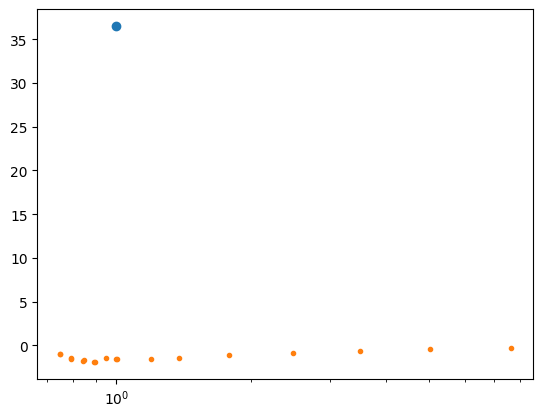

In [208]:
Literature = np.loadtxt("literature-data/excess-energy.dat")

volume_star = (23.79 * ureg.centimeter**3/ureg.mole).to(ureg.angstrom**3/ureg.mole)

for tau in [1]:

    volume = N_atom*volume_star*tau/Na
    box_size = volume**(1/3)

    mc = MonteCarlo(maximum_steps=20000,
        dumping_period=1000,
        thermo_period=1000,
        displace_mc = 2,
        desired_temperature = T.magnitude,
        number_atoms=[N_atom],
        epsilon=[epsilon.magnitude], 
        sigma=[sigma.magnitude],
        atom_mass=[m_argon.magnitude],
        box_dimensions=[box_size.magnitude,
                        box_size.magnitude,
                        box_size.magnitude],
        neighbor=10,
        # data_folder=
    )
    mc.run()

    Epot = np.loadtxt("Outputs/Epot.dat")[:,1][5:] # kcal/mol
    Epot = np.mean(Epot)*ureg.kcal/ureg.mol # kcal/mol

    # Eref = (3/2*kB*T*N_atom).to(ureg.kcal)*Na # kcal/mol
    # Epot = Epot.to(ureg.joule/ureg.mol) / Na
    # mean_of_U2 = np.mean((Epot/(kB*T*N_atom))**2)
    # square_of_mean_U = np.mean(Epot/(kB*T*N_atom))**2
    # Cv_over_R = N_atom*(mean_of_U2-square_of_mean_U)

    E_ideal = (3/2*kB*T*N_atom).to(ureg.kcal)*Na # kcal/mol
    Epot_corrected = (Epot - E_ideal).to(ureg.joule/ureg.mol) # J/mol
    E_excess = Epot_corrected / N_atom / R / T # no units

    plt.semilogx(tau, E_excess, "o")

plt.semilogx(Literature[:,0], Literature[:,1], '.')